### Machine Learning Audio Classification MEL CNN
In this document we will read in our feature npy files, construct, train and evaluate a model for audio classification:

Important Reads:
* https://arxiv.org/pdf/1807.09902.pdf (dataset paper)


In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import random
import math
import helper
import importlib
import h5py
import kapre
from kapre.composed import get_melspectrogram_layer
#from netplot import ModelPlot # this fucking library uses a weird version of numpy so we are not gonna use it
from tensorflow.keras.utils import plot_model
from datetime import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import backend as keras_backend
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *#Dense, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.regularizers import l2

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# set the random seed
tf.random.set_seed(42)
np.random.seed(42)

# are we resuming training?
resume = False

2.8.0
Num GPUs Available:  1


2022-02-17 01:21:41.866707: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-17 01:21:41.906682: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-17 01:21:41.906896: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


### MEL FEATURE READ IN
In this section we will read in our kaggle 2018 datasets which have already been featured extracted and normalized

In [2]:
# data set root
dataset_root_dir = os.path.join("/home/charlesedwards/Documents", 'kaggle_2018_dataset')

# get the train and test data directories
train_dir = os.path.join(dataset_root_dir, 'train')
test_dir = os.path.join(dataset_root_dir, 'test')

# get the catalog.csv for train and test directories
train_catalog_csv = os.path.join(train_dir, 'catalog.csv')
test_catalog_csv = os.path.join(test_dir, 'catalog.csv')

# read the catalog.csv files
train_metadata = pd.read_csv(train_catalog_csv)
test_metadata = pd.read_csv(test_catalog_csv)
metadata = pd.concat([train_metadata, test_metadata])

# the cached feature extraction data root folder
data_npy_folder = os.path.join(dataset_root_dir, 'data')

# load in pre-processed MEL train data
X = np.load( os.path.join(data_npy_folder, "X-mel-merged.npy" ))#, allow_pickle=True )
y = np.load( os.path.join(data_npy_folder, "y-mel-merged.npy" ))#, allow_pickle=True )

# # load in pre-processed MFCC train data
# X_test = np.load( os.path.join(data_npy_folder, "X-mfcc-test.npy" ))#, allow_pickle=True )
# y_test = np.load( os.path.join(data_npy_folder, "y-mfcc-test.npy" ))#, allow_pickle=True )


# # data set root
# dataset_root_dir = os.path.join("/home/charlesedwards/Documents", 'kaggle_2018_dataset')

# # get the train and test data directories
# train_dir = os.path.join(dataset_root_dir, 'train')
# test_dir = os.path.join(dataset_root_dir, 'test')

# # get the catalog.csv for train and test directories
# train_catalog_csv = os.path.join(train_dir, 'catalog.csv')
# test_catalog_csv = os.path.join(test_dir, 'catalog.csv')

# # read the catalog.csv files
# train_metadata = pd.read_csv(train_catalog_csv)
# test_metadata = pd.read_csv(test_catalog_csv)

# # the cached feature extraction data root folder
# data_npy_folder = os.path.join(dataset_root_dir, 'data')

# # load in pre-processed MFCC train data
# X_train = np.load( os.path.join(data_npy_folder, "X-mel-train.npy" ) )
# y_train = np.load( os.path.join(data_npy_folder, "y-mel-train.npy" ) )

# # load in pre-processed MFCC train data
# X_test = np.load( os.path.join(data_npy_folder, "X-mel-test.npy" ) )
# y_test = np.load( os.path.join(data_npy_folder, "y-mel-test.npy" ) )


In [3]:
indexes = []
total = len(metadata)
indexes = list(range(0, total))

# Randomize indexes
random.shuffle(indexes)

# Divide the indexes into Train and Test
test_split_pct = 20
split_offset = math.floor(test_split_pct * total / 100)

# Split the metadata
test_split_idx = indexes[0:split_offset]
train_split_idx = indexes[split_offset:total]


# Split the features with the same indexes
X_test = np.take(X, test_split_idx, axis=0)
y_test = np.take(y, test_split_idx, axis=0)
X_train = np.take(X, train_split_idx, axis=0)
y_train = np.take(y, train_split_idx, axis=0)

# Also split metadata
test_meta = metadata.iloc[test_split_idx]
train_meta = metadata.iloc[train_split_idx]

# Print status
print("Test split: {} \t\t Train split: {}".format(len(test_meta), len(train_meta)))
print("X test shape: {} \t X train shape: {}".format(X_test.shape, X_train.shape))
print("y test shape: {} \t\t y train shape: {}".format(y_test.shape, y_train.shape))

# # output X_train and X_test shape
# print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

# # output y_train and y_test shape
# print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

# # output X_train and X_test shape
# print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

# # output y_train and y_test shape
# print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

Test split: 2214 		 Train split: 8859
X test shape: (2214, 128, 259) 	 X train shape: (8859, 128, 259)
y test shape: (2214,) 		 y train shape: (8859,)


### Visualize the label count distribution for train and test data

<BarContainer object of 41 artists>

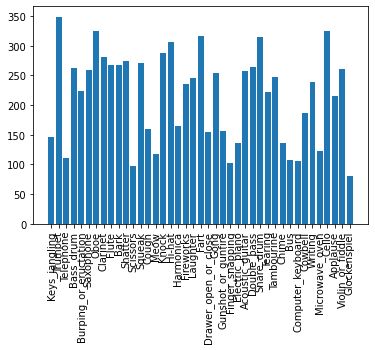

In [4]:
# visualize the label count distribution
labels = dict(zip(y_train,map(list(y_train).count, y_train)))
plt.xticks(rotation='vertical')
plt.bar(labels.keys(), labels.values())

<BarContainer object of 41 artists>

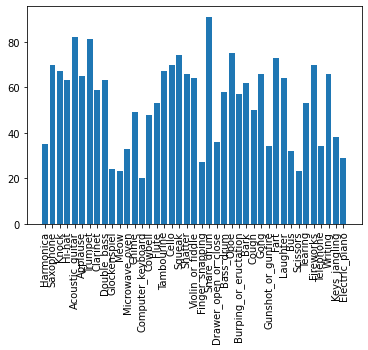

In [5]:
labels = dict(zip(y_test,map(list(y_test).count, y_test)))
plt.xticks(rotation='vertical')
plt.bar(labels.keys(), labels.values())

### Encode Labels
In this section we will encode to categorical our y data

In [6]:
# encode the labels to categorical
le = LabelEncoder()

y_train_encoded = to_categorical(le.fit_transform(y_train))
y_test_encoded = to_categorical(le.fit_transform(y_test))

In [7]:
# Total number of labels to predict (equal to the network output nodes)
num_labels = y_train_encoded.shape[1]

#n_c = 0
#y_train[0], y_train_encoded[0], num_labels
#y_train_encoded[n_c], le.classes_[n_c], num_labels

def get_integer_mapping(le):
    '''
    Return a dict mapping labels to their integer values
    from an SKlearn LabelEncoder
    le = a fitted SKlearn LabelEncoder
    '''
    res = {}
    for cl in le.classes_:
        res.update({cl:le.transform([cl])[0]})

    return res

get_integer_mapping(le)

{'Acoustic_guitar': 0,
 'Applause': 1,
 'Bark': 2,
 'Bass_drum': 3,
 'Burping_or_eructation': 4,
 'Bus': 5,
 'Cello': 6,
 'Chime': 7,
 'Clarinet': 8,
 'Computer_keyboard': 9,
 'Cough': 10,
 'Cowbell': 11,
 'Double_bass': 12,
 'Drawer_open_or_close': 13,
 'Electric_piano': 14,
 'Fart': 15,
 'Finger_snapping': 16,
 'Fireworks': 17,
 'Flute': 18,
 'Glockenspiel': 19,
 'Gong': 20,
 'Gunshot_or_gunfire': 21,
 'Harmonica': 22,
 'Hi-hat': 23,
 'Keys_jangling': 24,
 'Knock': 25,
 'Laughter': 26,
 'Meow': 27,
 'Microwave_oven': 28,
 'Oboe': 29,
 'Saxophone': 30,
 'Scissors': 31,
 'Shatter': 32,
 'Snare_drum': 33,
 'Squeak': 34,
 'Tambourine': 35,
 'Tearing': 36,
 'Telephone': 37,
 'Trumpet': 38,
 'Violin_or_fiddle': 39,
 'Writing': 40}

### Reshape Data
In this section we will reshape our X data to be placed into the neural network

In [8]:
# n_mfcc = 128 # IDK from orignal data shape I forgot to control n_fft and hop_length
# sampling_rate = 44100
# audio_duration = 7
# audio_length = audio_duration * sampling_rate
#(n_mfcc, 1 + int(np.floor(audio_length/512)), 1)
input_shape = (128, 259, 1)
input_shape

(128, 259, 1)

In [9]:
X_train = X_train.reshape(X_train.shape[0], *input_shape)
X_test = X_test.reshape(X_test.shape[0], *input_shape)

### Construct the model
In this section we will construct the model

In [10]:
if resume is False: # if we are not resuming from a previous model
    # Regularization rates
    spatial_dropout_rate_1 = 0.07
    spatial_dropout_rate_2 = 0.14
    l2_rate = 0.0005

    # Create a sequential object
    model = Sequential()
    model.add(LayerNormalization(input_shape=input_shape, axis=2, name='batch_norm'))
    # Conv 1
    model.add(Conv2D(filters=32, 
                        kernel_size=(3, 3), 
                        kernel_regularizer=l2(l2_rate)#, 
                        ))#input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(SpatialDropout2D(spatial_dropout_rate_1))
    model.add(Conv2D(filters=32, 
                        kernel_size=(3, 3), 
                        kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())


    # Max Pooling #1
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(SpatialDropout2D(spatial_dropout_rate_1))
    model.add(Conv2D(filters=64, 
                        kernel_size=(3, 3), 
                        kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(SpatialDropout2D(spatial_dropout_rate_2))
    model.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())


    # Reduces each h×w feature map to a single number by taking the average of all h,w values.
    model.add(GlobalAveragePooling2D())


    # Softmax output
    model.add(Dense(num_labels, activation='softmax'))

2022-02-17 01:21:45.955089: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-17 01:21:45.956480: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-17 01:21:45.956769: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-17 01:21:45.956980: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

### compile and visualise the model
Yes, batch size affects Adam optimizer. Common batch sizes 16, 32, and 64 can be used. Results show that there is a sweet spot for batch size, where a model performs best. For example, on MNIST data, three different batch sizes gave different accuracy as shown in the table below:
```
|Batch Size | Test Accuracy        |
-----------------------------------|
|1024       |  96% with 30 epochs  |
|64         |  98% with 30 epochs  |
|2          |  99% with 30 epochs  |
|__________________________________|
```
https://stats.stackexchange.com/questions/308424/how-does-batch-size-affect-adam-optimizer
<br>

### Categorical Crossentropy

**categorical_crossentropy:** Used as a loss function for multi-class classification model where there are two or more output labels. The output label is assigned one-hot category encoding value in form of 0s and 1. The output label, if present in integer form, is converted into categorical encoding using keras.

In [11]:
# 2. compile the model
if resume is False:
    learing_rate = 1e-4 #0.000001 # 5
    beta_1 = 0.99
    beta_2 = 0.999

    num_epochs = 500 # standard we are training for 500 epochsmodel_path
    num_batch_size = 32 # NOTE: for resnets batch size seems to be the best hyper parameter that improves performance

    model.compile(
        loss = "categorical_crossentropy", # mean absolute error predicted vs observed
        # previous failure training used 1e-4, beta_1=0.99, beta_2=0.999, only achieved a val_loss did not improve from 0.04701
        optimizer = tf.keras.optimizers.Adam(learning_rate=learing_rate, beta_1=beta_1, beta_2=beta_2), # stochastic gradient descent (lr=1e-3)
        metrics=['accuracy'] # metrics accuracy
    )

### visualise the model

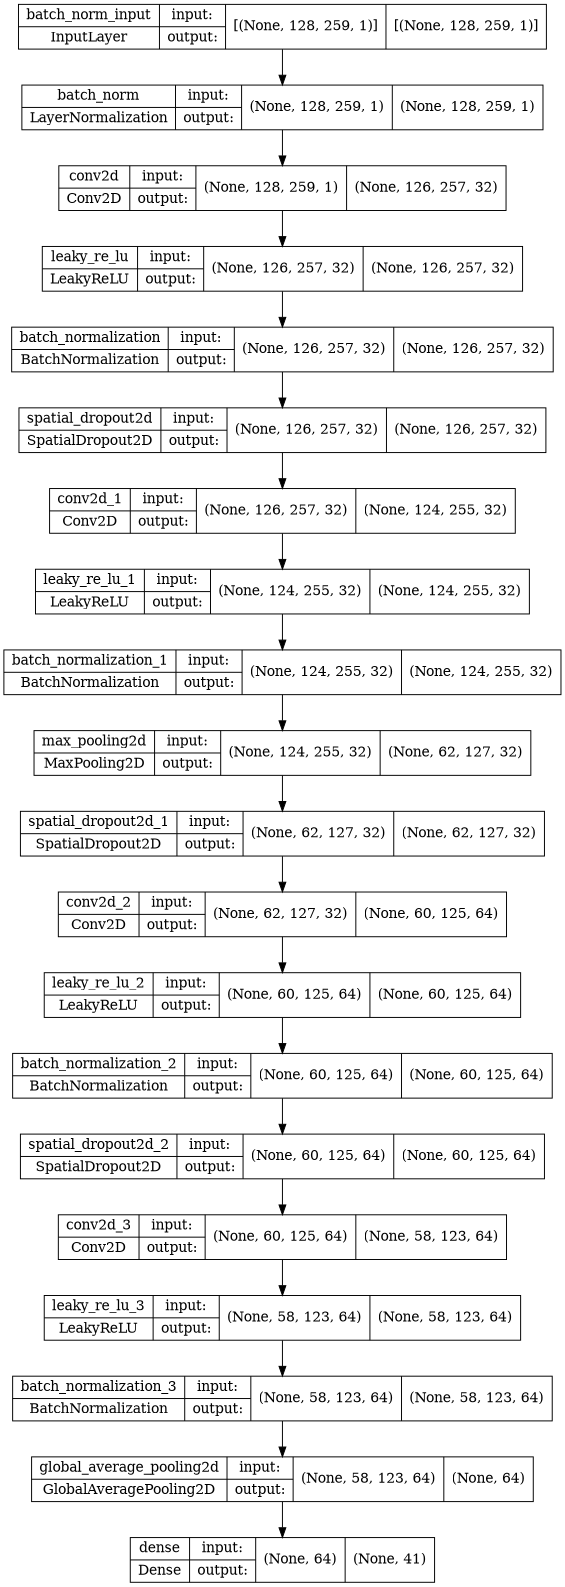

In [12]:

plot_model(model, show_shapes=True, expand_nested=True, dpi=70)

### train the model

In [13]:
# set the model path
model_dir = os.path.join( dataset_root_dir, 'models')

if resume is False:
    # this is where we will save the model too
    model_path = os.path.join(model_dir, f'MEL_CNN_lr-{learing_rate}_b1-{beta_1}_b2-{beta_2}_EPOCH-{num_epochs}_BATCH-{num_batch_size}_cc_v9.h5')
else:
    num_epochs = 500
    num_batch_size = 32 # recommend keeping same as saved model
    print("Resuming training...")
    model_path = os.path.join(model_dir, 'MEL_CNN_lr-0.0001_b1-0.99_b2-0.999_EPOCH-500_BATCH-32_cc_v8.h5')
    # Load best saved model
    print("Loading best saved model...")
    model = load_model(model_path)

model_path

'/home/charlesedwards/Documents/kaggle_2018_dataset/models/MEL_CNN_lr-0.0001_b1-0.99_b2-0.999_EPOCH-500_BATCH-32_cc_v9.h5'

In [14]:
# Save checkpoints
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_path, 
    verbose=1, 
    save_best_only=True
)

# early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=90#10#6#3
)

start = datetime.now()

# 3. train the model

history = model.fit(
    X_train, 
    y_train_encoded, 
    #validation_data=(X_test, y_test_encoded),
    batch_size=num_batch_size, 
    epochs=num_epochs, 
    validation_split=1/12.,
    callbacks=[checkpointer, early_stopping_callback], 
    verbose=1
)

end = datetime.now() - start
print("Training time: {}".format(end))

2022-02-17 01:21:47.324020: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1076776960 exceeds 10% of free system memory.
2022-02-17 01:21:48.012854: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1076776960 exceeds 10% of free system memory.


Epoch 1/500


2022-02-17 01:21:51.879152: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302


254/254 [==============================] - ETA: 0s - loss: 3.6913 - accuracy: 0.0698
Epoch 1: val_loss improved from inf to 3.72744, saving model to /home/charlesedwards/Documents/kaggle_2018_dataset/models/MEL_CNN_lr-0.0001_b1-0.99_b2-0.999_EPOCH-500_BATCH-32_cc_v9.h5
254/254 [==============================] - 32s 99ms/step - loss: 3.6913 - accuracy: 0.0698 - val_loss: 3.7274 - val_accuracy: 0.0447
Epoch 2/500
254/254 [==============================] - ETA: 0s - loss: 3.5445 - accuracy: 0.0888
Epoch 2: val_loss improved from 3.72744 to 3.50409, saving model to /home/charlesedwards/Documents/kaggle_2018_dataset/models/MEL_CNN_lr-0.0001_b1-0.99_b2-0.999_EPOCH-500_BATCH-32_cc_v9.h5
254/254 [==============================] - 24s 96ms/step - loss: 3.5445 - accuracy: 0.0888 - val_loss: 3.5041 - val_accuracy: 0.0839
Epoch 3/500
254/254 [==============================] - ETA: 0s - loss: 3.4596 - accuracy: 0.1054
Epoch 3: val_loss improved from 3.50409 to 3.37084, saving model to /home/charles

Text(0.5, 0, 'epochs')

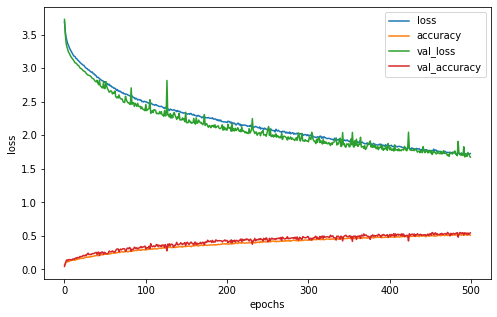

In [15]:
# plot history also known as loss curve 
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.ylabel("loss")
plt.xlabel("epochs")

In [16]:

model.metrics_names

['loss', 'accuracy']

In [17]:
# set the model path
model_dir = os.path.join( dataset_root_dir, 'models')
#model_path = os.path.join(model_dir, "V3/RESNET")
model_path = os.path.join(model_dir, f'MEL_CNN_lr-0.0001_b1-0.99_b2-0.999_EPOCH-500_BATCH-32_cc_v9.h5')

model = load_model(model_path)

In [18]:
importlib.reload(helper)
helper.model_evaluation_report(model, X_train, y_train_encoded, X_test, y_test_encoded)

2022-02-17 04:39:16.446776: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1174774272 exceeds 10% of free system memory.
2022-02-17 04:39:17.093405: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1174774272 exceeds 10% of free system memory.


70/70 [==============================] - 2s 24ms/step - loss: 1.8006 - accuracy: 0.5199
                    LOSS      ACCURACY
--------------------------------------
Training:         1.4248       62.0499
Test:             1.8006       51.9874
Normal diff         20.87 


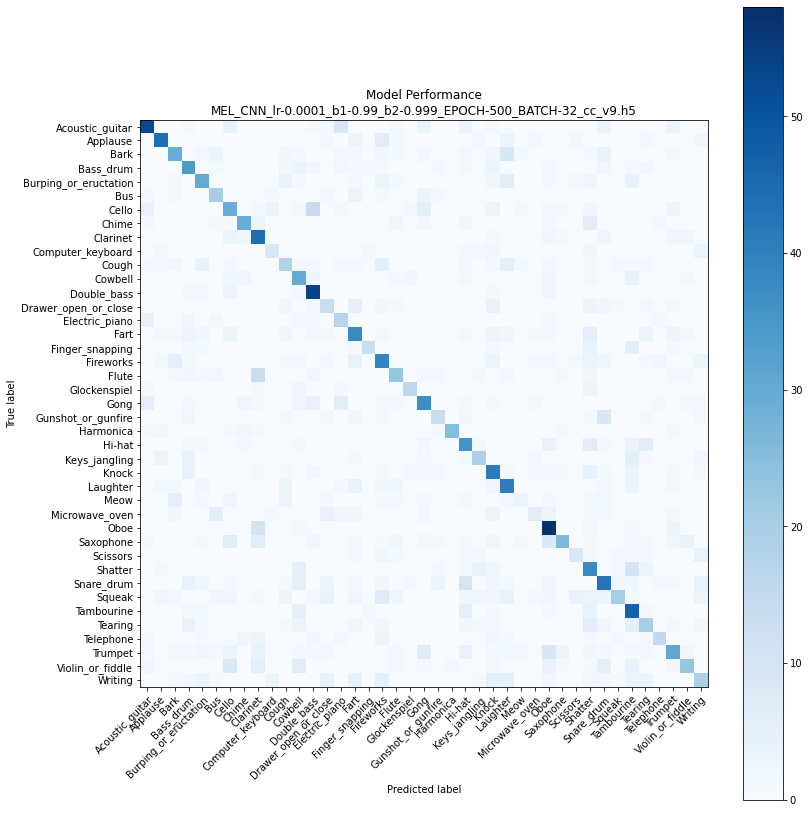

In [19]:

importlib.reload(helper)

# Sets decimal precision (for printing output only)
np.set_printoptions(precision=2)

# Predict probabilities for test set
y_probs = model.predict(X_test, verbose=0)

# Get predicted labels
yhat_probs = np.argmax(y_probs, axis=1)
y_trues = np.argmax(y_test_encoded, axis=1)

# Compute confusion matrix data
cm = confusion_matrix(y_trues, yhat_probs)

helper.plot_confusion_matrix(
    cm=cm,
    classes=le.classes_.tolist(),
    normalized=False, 
    title=f"Model Performance\n{model_path.split('/')[-1]}", 
    cmap=plt.cm.Blues,
    size=(12,12))

### Custom H5PY format
This section will append the label information into the h5 model so that our interface program can easily load these models

In [27]:
importlib.reload(helper)
model, metadata, dfe = helper.load_model_ext(model_path)
model, metadata, dfe

(<keras.engine.sequential.Sequential at 0x7f39e00387c0>,
 '["Acoustic_guitar", "Applause", "Bark", "Bass_drum", "Burping_or_eructation", "Bus", "Cello", "Chime", "Clarinet", "Computer_keyboard", "Cough", "Cowbell", "Double_bass", "Drawer_open_or_close", "Electric_piano", "Fart", "Finger_snapping", "Fireworks", "Flute", "Glockenspiel", "Gong", "Gunshot_or_gunfire", "Harmonica", "Hi-hat", "Keys_jangling", "Knock", "Laughter", "Meow", "Microwave_oven", "Oboe", "Saxophone", "Scissors", "Shatter", "Snare_drum", "Squeak", "Tambourine", "Tearing", "Telephone", "Trumpet", "Violin_or_fiddle", "Writing"]',
 'mel')

In [21]:
import json
lables_properly = le.classes_.tolist()
labels_json = json.dumps(list(lables_properly))
labels_json

'["Acoustic_guitar", "Applause", "Bark", "Bass_drum", "Burping_or_eructation", "Bus", "Cello", "Chime", "Clarinet", "Computer_keyboard", "Cough", "Cowbell", "Double_bass", "Drawer_open_or_close", "Electric_piano", "Fart", "Finger_snapping", "Fireworks", "Flute", "Glockenspiel", "Gong", "Gunshot_or_gunfire", "Harmonica", "Hi-hat", "Keys_jangling", "Knock", "Laughter", "Meow", "Microwave_oven", "Oboe", "Saxophone", "Scissors", "Shatter", "Snare_drum", "Squeak", "Tambourine", "Tearing", "Telephone", "Trumpet", "Violin_or_fiddle", "Writing"]'

In [26]:
helper.save_model_ext(model, model_path, overwrite=True, meta_data=labels_json, dfe="mel")